# 네이버 영화리뷰 감성분석 도전하기

**학습 목표**

텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.

RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.

IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다.

활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해서 사용 해보자

$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

### 1) 데이터 준비와 확인

In [2]:
# 필요한 라이브러리 사용하기
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

데이터의 중복 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어(Stopwords) 제거

사전 word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab # konlpy : 한국어 정보처리를 위한 파이썬 패키지 / Mecab : 형태소 분석기
import numpy as np
from collections import Counter # Counter 클래스는 파이썬의 기본 자료구조인 사전(dictionary)를 확장한다

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 지정

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 데이터의 중복 제거
    train_data = train_data.dropna(how = 'any')  # NaN 결측치 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 데이터의 중복 제거
    test_data = test_data.dropna(how = 'any')  # NaN 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

**회고**

밑에 x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index["<PAD>"], padding='post' ,maxlen=maxlen) 부분에서 <PAD>가 없다고 하는것 같은 오류가 떠서 <PAD>부분을 찾다보니 여기를 찾을수 있었음. 
그래서 index_to_word={}인 빈 딕셔너리를 만들어서 0,1,2 부분에 <PAD>,<BOS>,<UNK>를 넣으니까 오류가 안떠서 진행이 되는가 싶었는데 다시 또 <PAD>가 없다고 떠서 이게 뭔가 하고 보니 def wordlist_to_indexlist(wordlist) 이부분 안에 <PAD>가 아니라 빈칸이라 그랬었음 그래서 바꿨는데 또 오류가 떠서 위에 빈칸부분에 <PAD>,<BOS>,<UNK>를 넣으면 되는가 해서 넣었는데도 오류가 떠서 선배님들꺼 보고 해봤는데도 오류가 계속 뜨다가 계속 더 만져 봤는데 해결이 되었음
    


In [5]:
# 사전 딕셔러니 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
# 전체 데이터셋의 분포를 확인
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
# 패딩 이용해서 적절한 최대 문장 길이 지정
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='post' ,maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [9]:
# model 훈련 전에, 훈련용 데이터셋 분리
# 검증셋(validation set)으로 사용하도록 합니다. validation데이터는 몇 개가 좋을지 고민해봐
# validation set 30000건 분리 약 80:20으로 하기 위해 30000으로 지정했다
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


### 4) 모델 구성 및 validation set 구성모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [10]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.

**RNN 모델 사용**

In [11]:
# RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# model.fit() 과정의 train/validation loss, accuracy 등 매epoch마다 history 변수에 저장
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1816/1816 [==============================] - 22s 5ms/step - loss: 0.4372 - accuracy: 0.7830 - val_loss: 0.3553 - val_accuracy: 0.8465
Epoch 2/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3380 - accuracy: 0.8556 - val_loss: 0.3632 - val_accuracy: 0.8361
Epoch 3/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3216 - accuracy: 0.8644 - val_loss: 0.3465 - val_accuracy: 0.8487
Epoch 4/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3099 - accuracy: 0.8701 - val_loss: 0.3473 - val_accuracy: 0.8498
Epoch 5/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3001 - accuracy: 0.8748 - val_loss: 0.3495 - val_accuracy: 0.8505


In [13]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3570 - accuracy: 0.8459


### 6) Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


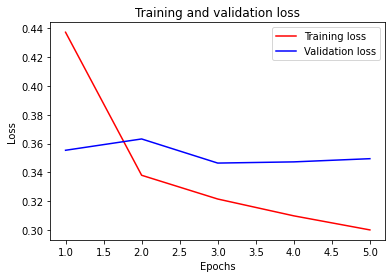

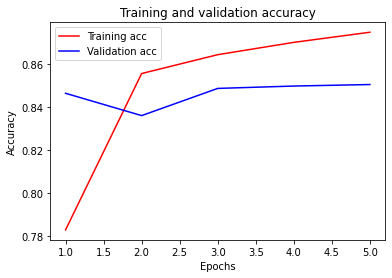

In [14]:
# Loss, Accuracy 그래프 시각화하기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 그리기 / 수행했던 딥러닝 학습이 잘 진행됐는지 확인
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss') # r은 빨간 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 학습이 적절한지 최적점을 추정
# validation loss의 그래프가 train loss와의 이격이 발생하면 더 이상의 트레이닝은 무의미

plt.clf()   # 그림을 초기화합니다 / 정확도 그래프 그려보자
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**CNN 모델로 사용**

In [15]:
# CNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# model.fit() 과정의 train/validation loss, accuracy 등 매epoch마다 history 변수에 저장
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1816/1816 [==============================] - 20s 4ms/step - loss: 0.4187 - accuracy: 0.8031 - val_loss: 0.3635 - val_accuracy: 0.8394
Epoch 2/5
1816/1816 [==============================] - 7s 4ms/step - loss: 0.3256 - accuracy: 0.8616 - val_loss: 0.3525 - val_accuracy: 0.8447
Epoch 3/5
1816/1816 [==============================] - 8s 4ms/step - loss: 0.2986 - accuracy: 0.8765 - val_loss: 0.3493 - val_accuracy: 0.8486
Epoch 4/5
1816/1816 [==============================] - 8s 4ms/step - loss: 0.2782 - accuracy: 0.8862 - val_loss: 0.3523 - val_accuracy: 0.8510
Epoch 5/5
1816/1816 [==============================] - 8s 4ms/step - loss: 0.2600 - accuracy: 0.8951 - val_loss: 0.3518 - val_accuracy: 0.8505


In [17]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.3636 - accuracy: 0.8470


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


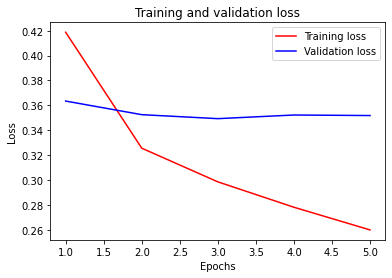

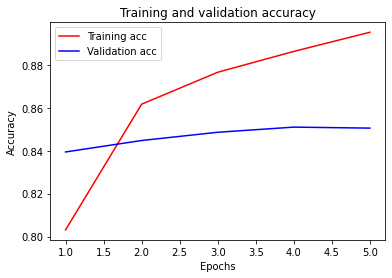

In [18]:
# Loss, Accuracy 그래프 시각화하기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 그리기 / 수행했던 딥러닝 학습이 잘 진행됐는지 확인
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss') # r은 빨간 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 학습이 적절한지 최적점을 추정
# validation loss의 그래프가 train loss와의 이격이 발생하면 더 이상의 트레이닝은 무의미

plt.clf()   # 그림을 초기화합니다 / 정확도 그래프 그려보자
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**GlobalMaxPooling1D() 레이어 하나만 사용**

In [19]:
# GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각해 볼 수 있습니다. 
# 전체 문장에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# model.fit() 과정의 train/validation loss, accuracy 등 매epoch마다 history 변수에 저장
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1816/1816 [==============================] - 6s 3ms/step - loss: 0.4981 - accuracy: 0.7563 - val_loss: 0.4055 - val_accuracy: 0.8151
Epoch 2/5
1816/1816 [==============================] - 6s 3ms/step - loss: 0.3822 - accuracy: 0.8311 - val_loss: 0.3882 - val_accuracy: 0.8264
Epoch 3/5
1816/1816 [==============================] - 6s 3ms/step - loss: 0.3566 - accuracy: 0.8442 - val_loss: 0.3859 - val_accuracy: 0.8286
Epoch 4/5
1816/1816 [==============================] - 6s 3ms/step - loss: 0.3422 - accuracy: 0.8513 - val_loss: 0.3873 - val_accuracy: 0.8290
Epoch 5/5
1816/1816 [==============================] - 6s 3ms/step - loss: 0.3326 - accuracy: 0.8558 - val_loss: 0.3907 - val_accuracy: 0.8285


In [21]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.3990 - accuracy: 0.8243


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


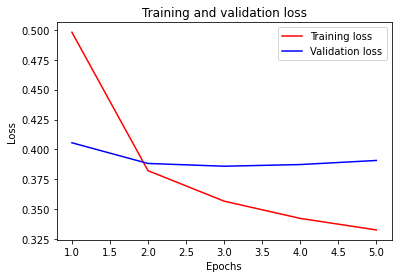

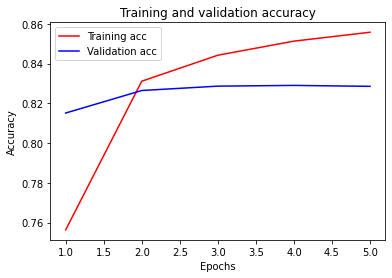

In [22]:
# Loss, Accuracy 그래프 시각화하기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 그리기 / 수행했던 딥러닝 학습이 잘 진행됐는지 확인
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.plot(epochs, loss, 'r', label='Training loss') # r은 빨간 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 학습이 적절한지 최적점을 추정
# validation loss의 그래프가 train loss와의 이격이 발생하면 더 이상의 트레이닝은 무의미

# Accuracy 그래프
plt.clf()   # 그림을 초기화합니다 / 정확도 그래프 그려보자
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석
임베딩 : 언어의 벡터화

In [23]:
import os
import gensim # gensim 자연어를 벡터로 변환하는데 필요한 편의기능을 제공하는 라이브러리
from gensim.models.keyedvectors import Word2VecKeyedVectors # Word2Vec : word to vec 단어를 벡터로 변환
from tensorflow.keras.initializers import Constant # Constant : 상수의 이름을 가지고 값을 가져올 때 사용하는 함수.

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 4)


In [24]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")


[('어땠', 0.9985105991363525),
 ('헌데', 0.9979478716850281),
 ('very', 0.9974331259727478),
 ('중복', 0.9971957206726074),
 ('SBS', 0.9970118403434753),
 ('아카데미', 0.9969988465309143),
 ('하구', 0.996618926525116),
 ('앙', 0.9966112375259399),
 ('콜린파렐', 0.996596097946167),
 ('갈망', 0.9965254068374634)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

https://github.com/Kyubyong/wordvectors 에서 적절한 ko.bin을 찾아 이용하세요. 

그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다

In [26]:
# gensim 4점대 버전은 안된다고 한다. 새로 깔아야 함


# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

In [27]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
k_word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [28]:
from gensim.models import KeyedVectors

vector = k_word2vec['사랑']
vector

/tmp/ipykernel_155/1911229901.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = k_word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [29]:
# word2vec으로 비슷한 단어 찾기
k_word2vec.similar_by_word("사랑")

/tmp/ipykernel_155/3092513330.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  k_word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [32]:
# 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in k_word2vec:
        embedding_matrix[i] = k_word2vec[index_to_word[i]]

/tmp/ipykernel_155/2899471328.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in k_word2vec:
/tmp/ipykernel_155/2899471328.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = k_word2vec[index_to_word[i]]


In [33]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1816/1816 [==============================] - 10s 5ms/step - loss: 0.4634 - accuracy: 0.7718 - val_loss: 0.3742 - val_accuracy: 0.8292
Epoch 2/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3350 - accuracy: 0.8559 - val_loss: 0.3452 - val_accuracy: 0.8496
Epoch 3/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2944 - accuracy: 0.8774 - val_loss: 0.3380 - val_accuracy: 0.8519
Epoch 4/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2629 - accuracy: 0.8923 - val_loss: 0.3511 - val_accuracy: 0.8548
Epoch 5/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2334 - accuracy: 0.9070 - val_loss: 0.3601 - val_accuracy: 0.8514


In [35]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3723 - accuracy: 0.8460


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


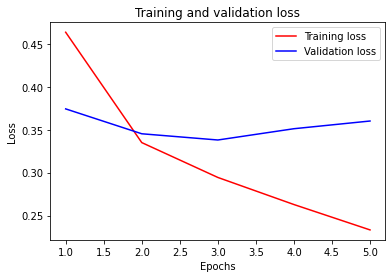

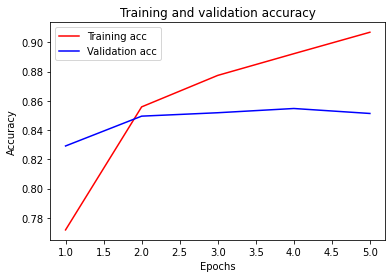

In [36]:
# Loss, Accuracy 그래프 시각화하기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 그리기 / 수행했던 딥러닝 학습이 잘 진행됐는지 확인
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.plot(epochs, loss, 'r', label='Training loss') # r은 빨간 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 학습이 적절한지 최적점을 추정
# validation loss의 그래프가 train loss와의 이격이 발생하면 더 이상의 트레이닝은 무의미

# Accuracy 그래프
plt.clf()   # 그림을 초기화합니다 / 정확도 그래프 그려보자
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
# RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1816/1816 [==============================] - 12s 6ms/step - loss: 0.4090 - accuracy: 0.8060 - val_loss: 0.3299 - val_accuracy: 0.8570
Epoch 2/5
1816/1816 [==============================] - 10s 6ms/step - loss: 0.2957 - accuracy: 0.8757 - val_loss: 0.3245 - val_accuracy: 0.8611
Epoch 3/5
1816/1816 [==============================] - 10s 6ms/step - loss: 0.2464 - accuracy: 0.8978 - val_loss: 0.3336 - val_accuracy: 0.8628
Epoch 4/5
1816/1816 [==============================] - 10s 6ms/step - loss: 0.2075 - accuracy: 0.9165 - val_loss: 0.3545 - val_accuracy: 0.8561
Epoch 5/5
1816/1816 [==============================] - 10s 6ms/step - loss: 0.1795 - accuracy: 0.9297 - val_loss: 0.3884 - val_accuracy: 0.8564


In [39]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3955 - accuracy: 0.8512


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


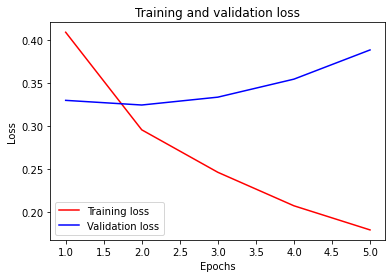

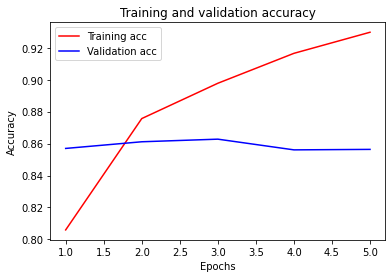

In [40]:
# Loss, Accuracy 그래프 시각화하기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 그리기 / 수행했던 딥러닝 학습이 잘 진행됐는지 확인
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.plot(epochs, loss, 'r', label='Training loss') # r은 빨간 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 학습이 적절한지 최적점을 추정
# validation loss의 그래프가 train loss와의 이격이 발생하면 더 이상의 트레이닝은 무의미

# Accuracy 그래프
plt.clf()   # 그림을 초기화합니다 / 정확도 그래프 그려보자
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
# CNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [42]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3920 - accuracy: 0.8206 - val_loss: 0.3310 - val_accuracy: 0.8565
Epoch 2/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2783 - accuracy: 0.8860 - val_loss: 0.3247 - val_accuracy: 0.8604
Epoch 3/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.1931 - accuracy: 0.9253 - val_loss: 0.3644 - val_accuracy: 0.8512
Epoch 4/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.1233 - accuracy: 0.9543 - val_loss: 0.4547 - val_accuracy: 0.8479
Epoch 5/5
1816/1816 [==============================] - 9s 5ms/step - loss: 0.0829 - accuracy: 0.9706 - val_loss: 0.5264 - val_accuracy: 0.8428


In [43]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.5446 - accuracy: 0.8357


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


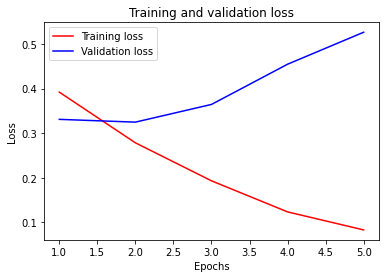

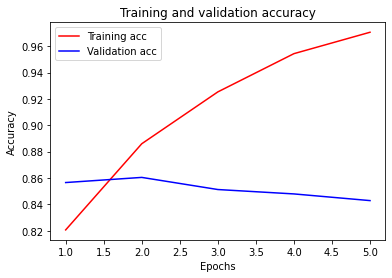

In [44]:
# Loss, Accuracy 그래프 시각화하기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 그리기 / 수행했던 딥러닝 학습이 잘 진행됐는지 확인
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.plot(epochs, loss, 'r', label='Training loss') # r은 빨간 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 학습이 적절한지 최적점을 추정
# validation loss의 그래프가 train loss와의 이격이 발생하면 더 이상의 트레이닝은 무의미

# Accuracy 그래프
plt.clf()   # 그림을 초기화합니다 / 정확도 그래프 그려보자
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [45]:
# GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각해 볼 수 있습니다. 
# 전체 문장에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1816/1816 [==============================] - 7s 4ms/step - loss: 0.4077 - accuracy: 0.8162 - val_loss: 0.3394 - val_accuracy: 0.8524
Epoch 2/5
1816/1816 [==============================] - 7s 4ms/step - loss: 0.2982 - accuracy: 0.8755 - val_loss: 0.3387 - val_accuracy: 0.8575
Epoch 3/5
1816/1816 [==============================] - 7s 4ms/step - loss: 0.2445 - accuracy: 0.9035 - val_loss: 0.3562 - val_accuracy: 0.8539
Epoch 4/5
1816/1816 [==============================] - 7s 4ms/step - loss: 0.1909 - accuracy: 0.9282 - val_loss: 0.3928 - val_accuracy: 0.8507
Epoch 5/5
1816/1816 [==============================] - 7s 4ms/step - loss: 0.1395 - accuracy: 0.9500 - val_loss: 0.4492 - val_accuracy: 0.8467


In [47]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.4666 - accuracy: 0.8423


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


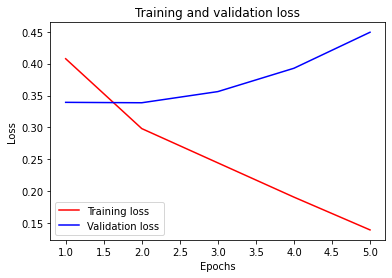

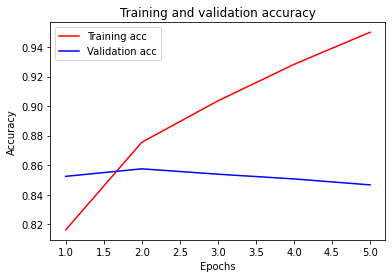

In [48]:
# Loss, Accuracy 그래프 시각화하기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 그리기 / 수행했던 딥러닝 학습이 잘 진행됐는지 확인
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.plot(epochs, loss, 'r', label='Training loss') # r은 빨간 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 학습이 적절한지 최적점을 추정
# validation loss의 그래프가 train loss와의 이격이 발생하면 더 이상의 트레이닝은 무의미

# Accuracy 그래프
plt.clf()   # 그림을 초기화합니다 / 정확도 그래프 그려보자
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**회고**

처음에 에포크를 20줬었는데 오르다가 떨어지고 유지만 되서 5정도 까지는 잘 올랐기 때문에 5로 지정했다. batch_size 조절함

RNN은 임베딩 전 0.8459 임베딩 후 0.8512 크게 오르진 않았지만 올랐고 85퍼 이상으로 올라감

CNN은 임베딩 전 0.8470 임베딩 후 0.8357 더 떨어짐 에포크도 3부터 떨어짐 CNN은 데이터 감성분석할때 별로 안좋은거 같음

GlobalMaxPooling1D() 레이어 하나만 사용하는 방법은 임페딩 전 0.8243 임베딩 후 0.8423 오르긴 했지만 85% 충족하지 못함

RNN으로 사용하는게 좋아보임 
